Training a qcgan with a gamma function with 6 parameters (1 layer)

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib.offsetbox import AnchoredText
import pandas as pd

[Qibo 0.1.7|INFO|2022-04-13 20:08:17]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-13 20:08:17]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-04-13 20:08:17]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-13 20:08:17]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


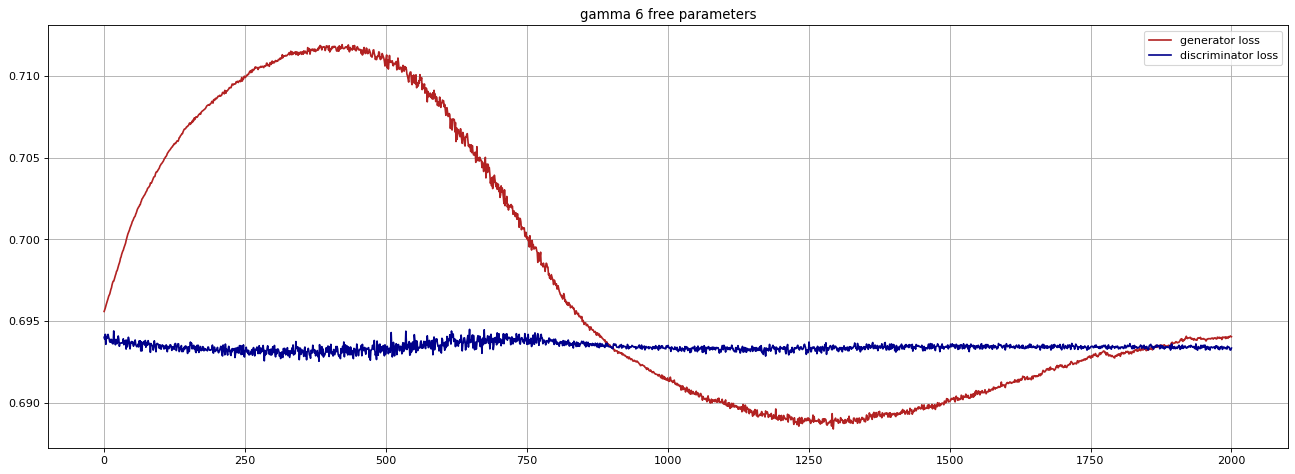

In [2]:
epochs=2000
d_loss = np.loadtxt(f"dloss_1Dgamma_1_3_1_10000_128_0.1_{epochs}", delimiter=' ')
g_loss= np.loadtxt(f"gloss_1Dgamma_1_3_1_10000_128_0.1_{epochs}", delimiter=' ')
#d_loss=d_loss[:5000]
#g_loss=g_loss[:5000]
pyplot.figure(figsize=(20, 7), dpi=80)
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss',color="firebrick")
pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss',color="darkblue")
pyplot.legend()
pyplot.title("gamma 6 free parameters")
pyplot.grid()
pyplot.show()
 

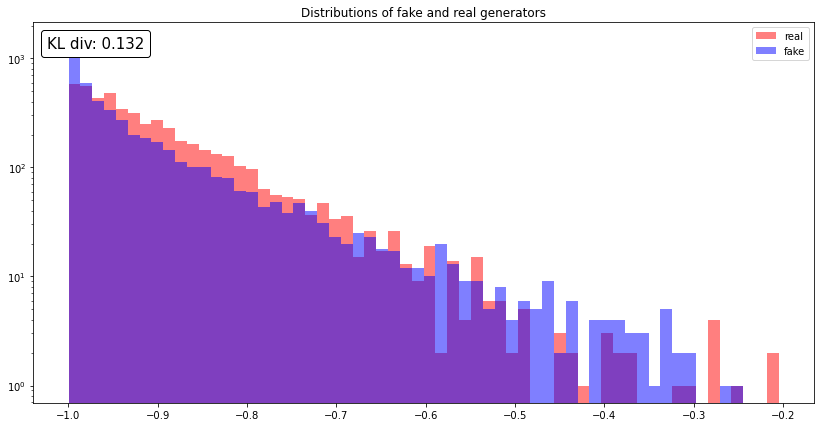

In [3]:
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems



# number of qubits generator
nqubits = 1
# create hamiltonians
hamiltonian1 = hamiltonian1()

latent_dim=3
samples=5000
nqubits=1
layers=1
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

params = np.loadtxt(f"PARAMS_1Dgamma_1_3_1_10000_128_0.1_{epochs}", delimiter=' ', unpack='true')
#print(params,epochs)
params = tf.Variable(params)

distributions=[]

x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1)

#x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
fig, ax = pyplot.subplots(figsize = (14, 7))
s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 3000)

distributions.append(x_real)
distributions.append(x_fake)

ax.set_yscale('log')
nbins=60
bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],color='blue', label='fake', alpha=0.5)

ax=pyplot.gca()
at = AnchoredText(
f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=15), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

pyplot.legend()
pyplot.title("Distributions of fake and real generators")
pyplot.show()

scala logaritmica

Calculation of the kl divergences: This formula has a problem: if there are bins with no elements the kl divergence diverges, this problem can be solved adding a small quantity at each bin.

In [4]:
from IPython.display import display
from scipy import stats

moments = pd.DataFrame(
    {
        "distribution":["real","fake 100000" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment ":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment ":[stats.moment(i,moment=4)[0] for i in distributions]
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment
0,real,-0.899288,0.009865,0.001920,0.000835
1,fake 100000,-0.918729,0.012306,0.003266,0.001525


KL DIVERGENCE: 0.08614548887044053


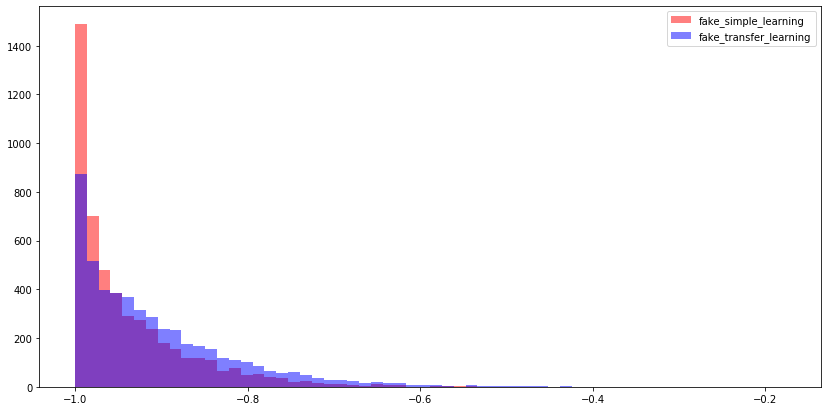

In [8]:
data=np.loadtxt('fake_data_6_params.dat')

pyplot.figure(figsize=(14, 7))

bins_data=pyplot.hist(data, bins=bins_real[1],color='red',label='fake_simple_learning', alpha=0.5)
bins_fake=pyplot.hist(x_fake1.numpy(), bins=bins_real[1],color='blue', label='fake_transfer_learning', alpha=0.5)

print("KL DIVERGENCE:",kl_divergence(bins_data[0],bins_fake[0],epsilon=0.1))


pyplot.legend()
pyplot.show()

In [6]:
# np.savetxt('fake_data.dat',x_fake)